# Tutorial 7: Visualize results

In [1]:
import os, warnings, torch

import torch.nn as nn
import scanpy as sc
import pandas as pd

from model.nicheTrans_img import *
from datasets.data_manager_breast_cancer import Breast_cancer

from utils.utils import *
from utils.utils_dataloader import *
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


from palettable.cartocolors.diverging import *
from palettable.scientific.diverging import *

## Load dataset

In [2]:
adata_path = '/home/wzk/ST_data/2024_NicheTrans_upload/2023_nc_10x_breast_cancer/HBC_rep1_cell_nucleus_3channel_strength_mean.h5ad'
coordinate_path = '/home/wzk/ST_data/2023_nc_Xenium_breast/In_situ_sample_1_replicate_1/outs/cells.csv.gz'
ct_path = '/home/wzk/ST_data/2023_nc_Xenium_breast/Cell_Barcode_Type_Matrices.xlsx'

adata = sc.read_h5ad(adata_path)
coordinates = pd.read_csv(coordinate_path, compression='gzip')
ct = pd.read_excel(ct_path, sheet_name='Xenium R1 Fig1-5 (supervised)') 

adata.obs['x'], adata.obs['y'] = coordinates['x_centroid'].values, coordinates['y_centroid'].values
adata.obs['ct'] = ct['Cluster'].values

adata.obsm['spatial'] = adata.obs[['x', 'y']].values

In [ ]:
centra = adata.obs['x'].values.max()//2
testing_adata = adata[ adata.obs['x'].values >= centra ]

## Load args

In [3]:
%run ./args/args_breast_cancer.py
args = args

## Create dataloader

In [4]:
# create the dataloaders
dataset = Breast_cancer(adata_path=args.adata_path, coordinate_path=args.coordinate_path, ct_path=args.ct_path)
trainloader, testloader = breast_cancer_dataloader(args, dataset)

------Calculating spatial graph...
The graph contains 1185564 edges, 98797 cells.
12.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 827796 edges, 68983 cells.
12.0000 neighbors per cell on average.
=> AD Mouse loaded
Dataset statistics:
  ------------------------------
  subset   | # num | 
  ------------------------------
  train    |  98797 spots, 98659 positive CD20, 84043 positive HER2 
  test     |  68983 spots, 67600 positive CD20, 36904 positive HER2 
  ------------------------------


## Model initialization

In [ ]:
# create the model
source_dimension, target_dimension = dataset.rna_length, dataset.protein_length
model = NicheTrans(source_length=source_dimension, target_length=target_dimension, noise_rate=args.noise_rate, dropout_rate=args.dropout_rate)
model = nn.DataParallel(model).cuda()

model.load_state_dict(torch.load('NicheTrans_breast_cancer_last.pth'))
model.eval() 

DataParallel(
  (module): NicheTrans(
    (encoder): NetBlock(
      (noise_dropout): Dropout(p=0.2, inplace=False)
      (linear_list): ModuleList(
        (0): Linear(in_features=313, out_features=512, bias=True)
        (1): Linear(in_features=512, out_features=256, bias=True)
      )
      (bn_list): ModuleList(
        (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation_list): ModuleList(
        (0-1): 2 x LeakyReLU(negative_slope=0.01)
      )
      (dropout_list): ModuleList(
        (0): Dropout(p=0.2, inplace=False)
      )
    )
    (fusion_omic): Self_Attention(
      (to_q): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=False)
      )
      (to_k): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=False)
      )
      (to_v): Linear(in_features=256, out_features=256, bias=Fa

## Model inference 

In [8]:
pd_value, gt_value = [], [] 

with torch.no_grad():
    for _, (rna, protein, rna_neighbors, _) in enumerate(testloader):

        rna, protein, rna_neighbors = rna.cuda(), protein.cuda(), rna_neighbors.cuda()
        source, target, source_neightbors = rna, protein, rna_neighbors

        outputs = model(source, source_neightbors)

        pd_value.append(outputs)
        gt_value.append(target)

pd_value = torch.cat(pd_value, dim=0).cpu().numpy()
gt_value = torch.cat(gt_value, dim=0).cpu().numpy()

## Model evaluation

In [9]:
from utils.evaluation import evaluator
pearson_sample_list, spearman_sample_list, _ = evaluator(pd_value, gt_value, training=False, panel=dataset.target_panel)

print(pearson_sample_list.mean())
print(spearman_sample_list.mean())

0.8175893854649893
0.752894196926919


In [11]:
pd_value = np.exp(pd_value) - 1
gt_value = np.exp(gt_value) - 1

In [27]:
testing_adata.obs['pd_CD20'] = pd_value[:, 0]
testing_adata.obs['pd_HER2'] = pd_value[:, 1]

<Axes: title={'center': 'Prediction CD20'}, xlabel='spatial1', ylabel='spatial2'>

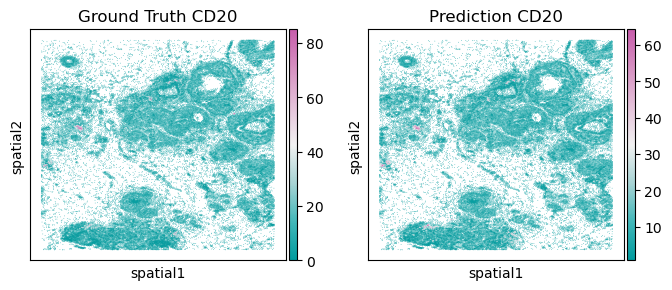

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sc.pl.embedding(testing_adata, basis='spatial', color='cell_CD20_mean', title=f'Ground Truth CD20', ax=axs[0], show=False, cmap=Tropic_7.mpl_colormap, size=1) 
sc.pl.embedding(testing_adata, basis='spatial', color='pd_CD20', title=f'Prediction CD20', ax=axs[1], show=False, cmap=Tropic_7.mpl_colormap, size=1) 

<Axes: title={'center': 'Prediction HER2'}, xlabel='spatial1', ylabel='spatial2'>

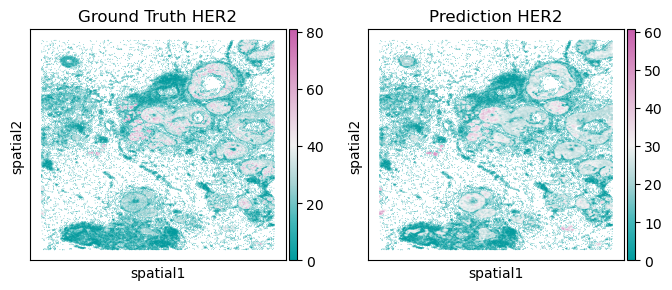

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sc.pl.embedding(testing_adata, basis='spatial', color='cell_HER2_mean', title=f'Ground Truth HER2', ax=axs[0], show=False, cmap=Tropic_7.mpl_colormap, size=1) 
sc.pl.embedding(testing_adata, basis='spatial', color='pd_HER2', title=f'Prediction HER2', ax=axs[1], show=False, cmap=Tropic_7.mpl_colormap, size=1) 